# BARABÁSI-ALBERT MODEL

## Six Degrees of Kevin Bacon

![kevin](Kevin_Bacon.jpg)


1994.godine glumac Kevin Bacon je u intervjuu izjavio da je radio sa svakim glumcem u Hollywoodu ili s nekim tko je s njime radio.

Temeljem toga inspirirana je igra koja svakom glumcu pridružuje *Bacon*-ov broj koji govori koliko je osoba udaljena od Kevina Bacona s obzirom na osobe s kojima je surađivala na filmovima.
* Kevin Bacon ima Baconov broj 0
* Osoba koja je direktno surađivala s njime 1
* Ako je najmanji Baconov broj od svih osoba s kojima je neka osoba surađivala N onda je njen Baconov broj N+1

Npr. Ian McKellen je glumio u *X-Men:Days of Future Past(2014)* s Michaelom Fassbenderom i Jamesom McAvoyem, a McAvoy i Fassbender su glumili s Baconom u *X-Men: First Class (2011)*. Stoga McAvoy i Fassbender imaju Baconov broj 1 dok McKellen ima Baconov broj 2.

Pretpostavka je da ni za jednog glumca ovaj broj ne prelazi 6. Naziv je inspiriran s 6 stupnjeva separacije ili pravilom 6 rukovanja koje kaže da su bilo koja dva čovjeka udaljena poznanstvima u najviše šest koraka.

Kevin Bacon je 2007. godine pokrenuo dobrotvornu udrugu [Six Degrees](https://en.wikipedia.org/wiki/SixDegrees.org)

## Mali svijet

Ja se neću ovdje baviti koliki je Baconov broj svakog glumca već ću kroz jedan model pokušati objasniti zašto je svijet tako mali.

Prikažimo glumce kao vrhove u grafu gdje bridovi predstavljaju filmove u kojem su dva glumca glumila zajedno. Npr. 

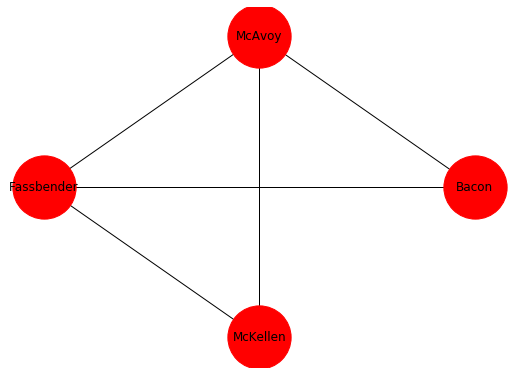

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

g=nx.Graph()
g.add_edge('Bacon','McAvoy') 
g.add_edge('Bacon','Fassbender')
g.add_edge('Fassbender','McAvoy')
g.add_edge('Fassbender','McKellen')
g.add_edge('McAvoy','McKellen')

pos = nx.shell_layout(g)
plt.figure(figsize=(7,5))
nx.draw(g, pos, node_size=4000, with_labels=True, node_color='r')
plt.show()

In [8]:
list(g.edges('Bacon'))

[('Bacon', 'McAvoy'), ('Bacon', 'Fassbender')]

## Scale free network
Stupanj vrha je broj bridova koji iz njega izlazi.

Distribucija stupnjeva je vjerojatnosna distribucija stupnjeva u cijelom grafu. To jest distribucija stupnja $P(k)$ je udio vrhova u grafu koji imaju stupanj $k$. Odnosno ako u grafu s $n$ vrhova ima $n_{k}$ vrhova stupnja k tada je $P(k)=\frac{n_{k}}{n}$

Za graf kažemo da je *scale-free* ako distribucija stupnjeva zadovoljava *power law* odnosno oblika je $P(k)=\alpha x^{-k}$

Promotrimo model koji generira *scale-free* graf.

## Barabasi-Albert model

Krećemo s grafom od $m_{0}$ čvorova koji mogu biti proizvoljno povezani.
* **Rast**: u svakom koraku dodajemo novi vrh koji povežemo s $m$ vrhova koji su već u grafu
* **Preferential attachment**: vjerojatnost da se novi vrh poveže s vrhom $i$ je $\pi(k_{i})=\frac{k_{i}}{\sum k_{i}}$ gdje je $k_{i}$ stupanj vrha i.


In [45]:
import numpy as np

def display_graph(G):
    pos=nx.circular_layout(G)
    boje=['g' for k in range(i)]
    boje.append('r')
    nx.draw(G,pos,node_color=boje,edge_color='black',node_size=1000)
    
    node_pr=node_prob(G)
    labels={}
    for k in range(i):
        labels[k]=f'{node_pr[k]:.2f}'
    labels[i]='new'    
    nx.draw_networkx_labels(G,pos,labels)
    nx.draw_networkx_edges(G,pos,edgelist=list(G.edges(i)),edge_color='r')
    
    return
   
    
def node_prob(G):
    degrees=np.array(nx.degree(G))[:,1]
    node_pr=degrees/(2*len(G.edges()))
    
    return node_pr


def add_node(G,i,m):
    node_pr=node_prob(G)
    cumulative_node_prob=[]
    it=0
    for p in node_pr:
        cumulative_node_prob.append(it+p)
        it=it+p

    G.add_node(i)
   
    num_edges_added=0
    selected_nodes=[]
    #new_edges=[]

    while(num_edges_added<m):
        node_it=0
        u=np.random.uniform(0,1)
        while(u>cumulative_node_prob[node_it]):
            node_it+=1

        selected_node=node_it
        
        if selected_node in selected_nodes:
            continue
        
        selected_nodes.append(selected_node)

        G.add_edge(i,selected_node)
        num_edges_added+=1
        #new_edges.append((i,selected_node))
    
    return 

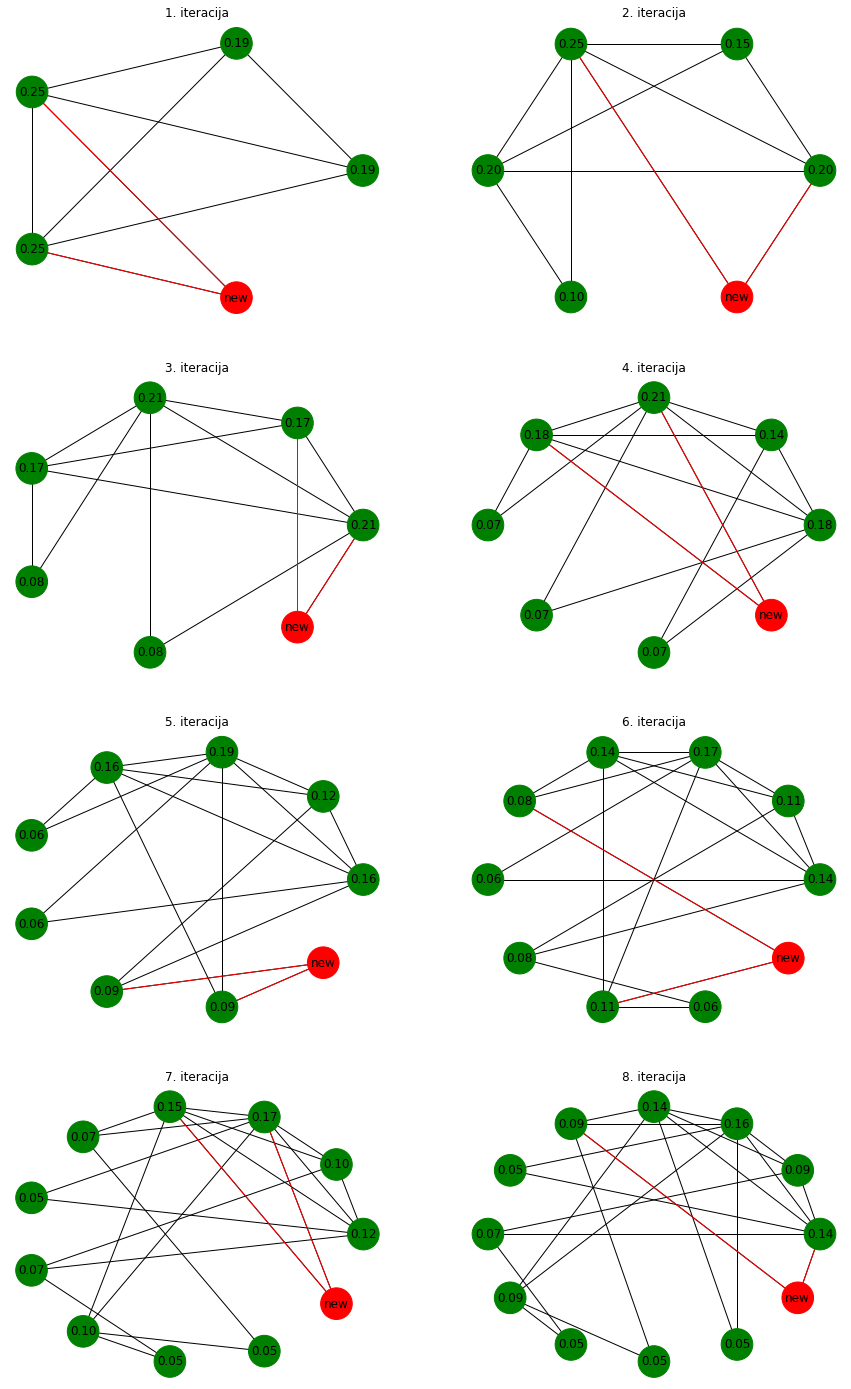

In [53]:
plt.rcParams['figure.figsize'] = [15,25]
m0=4
m=2
n=12

G=nx.complete_graph(m0)
for i in range(m0,n):
    add_node(G,i,m)
    plt.subplot(4,2,i-3)
    plt.title(f'{i-3}. iteracija')
    display_graph(G)

plt.show()
    
    

In [ ]:
def plot_deg_dist(G,b):
    all_degrees=[]
    for i in nx.degree(G):
        all_degrees.append(i[1])
    different_degrees=list(set(all_degrees))
    prob_of_degrees=[]

    min=10000
    max=0
    for i in all_degrees:
        if i>max:
            max=i
        if i<min:
            min=i

    for i in different_degrees:
        c=(float)(all_degrees.count(i))/len(all_degrees)
        prob_of_degrees.append(c)

    x=range(min,max+1)
    xn=[]
    y=[]
    l=G.number_of_nodes()
    for i in x:
        t=(i**-3)*32
        if(t>=1/l):
            xn.append(i)
            y.append(t)
        else:
            break

    plt.loglog(different_degrees,prob_of_degrees,'ro',basex=10,basey=10)
    plt.plot(xn,y,'--c')
    plt.xlabel('k')
    plt.ylabel('pk')
    plt.title('Degree distribution')
    plt.savefig('C:/Users/Dario/Desktop/faks/3.godina/Odabrane primjene vjerojatnosti/ba grafovi/deg_dist{}.png'.format(b), bbox_inches='tight')
    plt.show()

Pratimo promjenu stupnja vrha $i$ kroz vrijeme.

$\frac{\partial k_{i}}{\partial t}\propto m \frac{k_{i}}{\sum_{i=1}^{N-1} k_{i}}$

gdje je $t$ vremenski korak a N ukupan broj čvorova u grafu. Naime u svakom koraku dodajemo $m$ novih bridova a svaki ima vjerojatnost $\frac{k_{i}}{\sum_{i=1}^{N-1} k_{i}}$ da se poveže s $i$. ...